In [100]:
import pandas as pd
import matplotlib as plt
import numpy as np 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import cross_validation, metrics
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [101]:
X_train = pd.read_csv("train.csv", index_col = 0)
X_test = pd.read_csv("test.csv", index_col = 0)
X_train['source'] = 'train'
X_test['source'] = 'test'
X = pd.concat([X_train, X_test], ignore_index = True)
print X_train.shape, X_test.shape, X.shape

(1460, 81) (1459, 80) (2919, 81)


In [91]:
X.drop(X[(X['GarageCars'].isnull()|X['GarageArea'].isnull()) & (X['source'] != 'test')].index, inplace = True)
X.loc[X['BsmtFinSF1'].isnull()&X['BsmtFinType1'].isnull(), 'BsmtFinSF1'] = 0.0 
X.loc[X['BsmtFinSF2'].isnull()&X['BsmtFinType2'].isnull(), 'BsmtFinSF2'] = 0.0
X.drop(X[(X['BsmtFinSF1'] > 0) &(X['BsmtFinType1'].isnull()) & (X['source']!='test')].index, inplace = True)
X.drop(X[(X['BsmtFinSF2'] > 0)&(X['BsmtFinType2'].isnull()) & (X['source']!='test')].index, inplace = True)

X.loc[X['TotalBsmtSF'].isnull()&X['BsmtCond'].isnull(), 'TotalBsmtSF'] = 0.0  

X = X.fillna('NN')

ordered_val = ['NN', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
X['FireplaceQu'] = X['FireplaceQu'].astype('category', ordered = True, categories = ordered_val).cat.codes



In [92]:
X = X[['OverallQual', 'GarageArea', 'GrLivArea', 'TotalBsmtSF',
       'GarageCars', '1stFlrSF', 'YearBuilt',
       'BsmtFinSF1', 'SalePrice', 'source']]
X.dtypes

OverallQual      int64
GarageArea      object
GrLivArea        int64
TotalBsmtSF    float64
GarageCars      object
1stFlrSF         int64
YearBuilt        int64
BsmtFinSF1     float64
SalePrice       object
source          object
dtype: object

In [93]:
X.apply(lambda x: x.isnull().sum())

OverallQual    0
GarageArea     0
GrLivArea      0
TotalBsmtSF    0
GarageCars     0
1stFlrSF       0
YearBuilt      0
BsmtFinSF1     0
SalePrice      0
source         0
dtype: int64

In [94]:
X['YearBuilt'] = 2011 - X['YearBuilt']

X_train = X[X['source'] == 'train']
X_test = X[X['source'] == 'test']
X_train = X_train.drop(labels = ['source'], axis = 1)
X_test = X_test.drop(labels = ['source', 'SalePrice'], axis = 1)


y_train = X_train['SalePrice'].copy()
X_train = X_train.drop(labels = ['SalePrice'], axis = 1)
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0)



In [95]:
model = ensemble.RandomForestRegressor( n_estimators = 200, random_state = 0)

In [97]:
model = ensemble.RandomForestRegressor(oob_score = True, n_estimators = 200, random_state = 0, max_features = 2, min_samples_split = 5, bootstrap = True, max_depth = None, min_samples_leaf = 1)

In [96]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 8),
              "min_samples_split": randint(2, 8),
              "min_samples_leaf": randint(1, 8),
              "bootstrap": [True, False]}

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
random_search.fit(X_train_train, y_train_train)
report(random_search.cv_results_)



Model with rank: 1
Mean validation score: 0.837 (std: 0.038)
Parameters: {'max_features': 2, 'min_samples_split': 5, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1}

Model with rank: 2
Mean validation score: 0.836 (std: 0.040)
Parameters: {'max_features': 3, 'min_samples_split': 2, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2}

Model with rank: 3
Mean validation score: 0.835 (std: 0.042)
Parameters: {'max_features': 4, 'min_samples_split': 3, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4}



Model with rank: 1
Mean validation score: 0.847 (std: 0.039)
Parameters: {'max_features': 5, 'min_samples_split': 4, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1}

Model with rank: 2
Mean validation score: 0.845 (std: 0.039)
Parameters: {'max_features': 8, 'min_samples_split': 3, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1}

Model with rank: 3
Mean validation score: 0.843 (std: 0.038)
Parameters: {'max_features': 2, 'min_samples_split': 3, 'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2}

Model with rank: 3
Mean validation score: 0.843 (std: 0.038)
Parameters: {'max_features': 2, 'min_samples_split': 4, 'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2}

cv_score mean: 3.022e+04
rmse: 9.734e+08
oob score 0.8291
test score 0.8604

cv_score mean: 3.06e+04
rmse: 9.396e+08
oob score 0.8271
test score 0.8652

cv_score mean: 3.029e+04
rmse: 9.287e+08
test score 0.8668

In [98]:
model.fit(X_train_train, y_train_train)
#prediction_test = model.predict(X_test)


prediction_train_train = model.predict(X_train_train)
prediction_train_test = model.predict(X_train_test)
cv_score = cross_validation.cross_val_score(model, X_train_train, y_train_train, cv = 20, scoring = 'mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))
rmse = np.mean(metrics.mean_squared_error(y_train_test, prediction_train_test))
print "cv_score mean: %.4g" % np.mean(cv_score)
print "rmse: %.4g" % rmse
print "oob score %.4g" % model.oob_score_
print "test score %.4g" % model.score(X_train_test, y_train_test)


/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/kuncoro/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


cv_score mean: 3.063e+04
rmse: 1.083e+09
oob score 0.8326
test score 0.8446


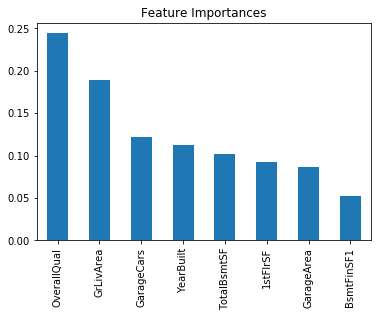

In [99]:
coef = pd.Series(model.feature_importances_, X_train_train.columns ).sort_values(ascending=False)
coef.plot(kind = 'bar', title = "Feature Importances")

In [75]:
X_test.apply(lambda x: x.isnull().sum())

OverallQual    0
GarageArea     1
GrLivArea      0
TotalBsmtSF    0
GarageCars     1
1stFlrSF       0
YearBuilt      0
FireplaceQu    0
BsmtFinSF1     0
dtype: int64

In [76]:
X_test.fillna(0)

,OverallQual,GarageArea,GrLivArea,TotalBsmtSF,GarageCars,1stFlrSF,YearBuilt,FireplaceQu,BsmtFinSF1
1460,5,730.0,896,882.0,1.0,896,50,-1,468.0
1461,6,312.0,1329,1329.0,1.0,1329,53,-1,923.0
1462,5,482.0,1629,928.0,2.0,928,14,3,791.0
1463,6,470.0,1604,926.0,2.0,926,13,4,602.0
1464,8,506.0,1280,1280.0,2.0,1280,19,-1,263.0
1465,6,440.0,1655,763.0,2.0,763,18,3,0.0
1466,6,420.0,1187,1168.0,2.0,1187,19,-1,935.0
1467,6,393.0,1465,789.0,2.0,789,13,4,0.0
1468,7,506.0,1341,1300.0,2.0,1341,21,1,637.0
1469,4,525.0,882,882.0,2.0,882,41,-1,804.0


In [ ]:
y_submission['Id'] = xrange(1461,2920)
y_submission['SalePrice'] = prediction_test
y_submission

In [108]:
X_test[X_test['MSZoning'].isnull()] 

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,source
Id,,,,,,,,,,,,,,,,,,,,,
1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,...,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal,test
2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml,test
2251,70,NaN,NaN,56600,Pave,NaN,IR1,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,test
2905,20,NaN,125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,test


In [109]:
import sys
print sys.path

['', '/Users/kuncoro/anaconda/lib/python27.zip', '/Users/kuncoro/anaconda/lib/python2.7', '/Users/kuncoro/anaconda/lib/python2.7/plat-darwin', '/Users/kuncoro/anaconda/lib/python2.7/plat-mac', '/Users/kuncoro/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/kuncoro/anaconda/lib/python2.7/lib-tk', '/Users/kuncoro/anaconda/lib/python2.7/lib-old', '/Users/kuncoro/anaconda/lib/python2.7/lib-dynload', '/Users/kuncoro/anaconda/lib/python2.7/site-packages', '/Users/kuncoro/anaconda/lib/python2.7/site-packages/Sphinx-1.5.6-py2.7.egg', '/Users/kuncoro/anaconda/lib/python2.7/site-packages/aeosa', '/Users/kuncoro/anaconda/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/Users/kuncoro/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/kuncoro/.ipython']


In [3]:
import pandas as pd
df = pd.DataFrame({"A": [1, 2, 3], "B": [4, 5, 6]})

In [6]:
df = df.rename_axis('foo')

In [7]:
df

,A,B
foo,,
0,1,4
1,2,5
2,3,6
